####IMPORTS


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, inconsistent
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import pdist
import numpy as np
import plotly.express as px
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


####DATA FILTERING

In [ ]:
# columns_to_keep = [
#     'country', 'electricity_generation', 'population', 'gdp', 'electricity_demand', 'solar_consumption', 'wind_consumption',
#     'gas_consumption', 'hydro_consumption', 'oil_consumption'
# ]

# countries = [
#     'Slovakia', 'France', 'Czechia', 'Spain', 'Germany', 'Croatia', 'Greece',
#     'Norway', 'Venezuela', 'Colombia', 'Vietnam', 'Thailand', 'Japan', 'Denmark',
#     'Hungary', 'Estonia', 'Poland', 'South Korea', 'Mexico', 'Egypt', 'Morocco',
#     'Turkey', 'Italy', 'Portugal', 'Peru', 'Lithuania', 'Latvia', 'Slovenia', 'Saudi Arabia'
# ]

# # Apply the filters to the DataFrame
# filtered_df = df[
#     (df['country'].isin(countries)) &
#     (df['year'].isin([2015]))
# ][columns_to_keep]

# # Display the filtered data
# pd.set_option('display.max_rows', None)     #Show all rows
# pd.set_option('display.max_columns', None)   # Show all columns
# print(filtered_df)

# filtered_df.to_csv('WEC_final_dataset.csv', index=False)

####LOADING ALREADY FILTERED DATASET

In [ ]:
filtered_df = pd.read_csv("WEC_final_dataset.csv")
filtered_df.head()

,country,electricity_generation,population,gdp,electricity_demand,solar_consumption,wind_consumption,gas_consumption,hydro_consumption,oil_consumption
0,Colombia,76.22,47119728.0,6.153395e+11,75.81,0.000,0.184,112.117,120.327,179.192
1,Croatia,11.25,4254821.0,7.822143e+10,18.04,0.154,2.144,24.212,17.210,39.127
2,Czechia,82.52,10523801.0,2.966496e+11,70.01,6.105,1.542,75.395,4.835,104.877
3,Denmark,28.93,5677795.0,2.536830e+11,34.84,1.627,38.060,33.093,0.049,84.775
4,Egypt,186.32,97723792.0,1.058644e+12,185.63,0.113,5.102,460.188,36.849,460.149


####DISPLAY OF INITIAL HIERARCHICAL CLUSTERING

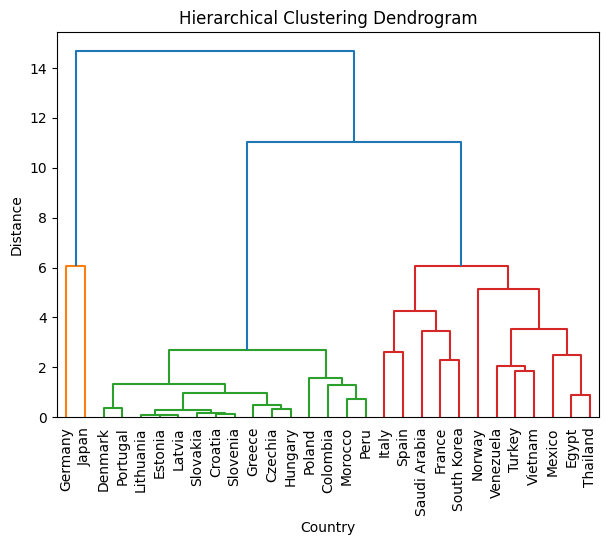

In [ ]:
# Remove non-numeric columns for clustering - country
df_numeric = filtered_df.drop(columns=['country'])

df_numeric = df_numeric.fillna(0)

# Standardize the data - we have big range of values because of the size o gdp vs. consumption data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Initial Hierarchical Clustering

linked = linkage(df_scaled, method='ward')

#Plot of the Dendrogram
plt.figure(figsize=(7, 5))
dendrogram(linked, labels=filtered_df['country'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Country")
plt.ylabel("Distance")
plt.show()

####DISPLAY OF INITIAL CLUSTERMAP

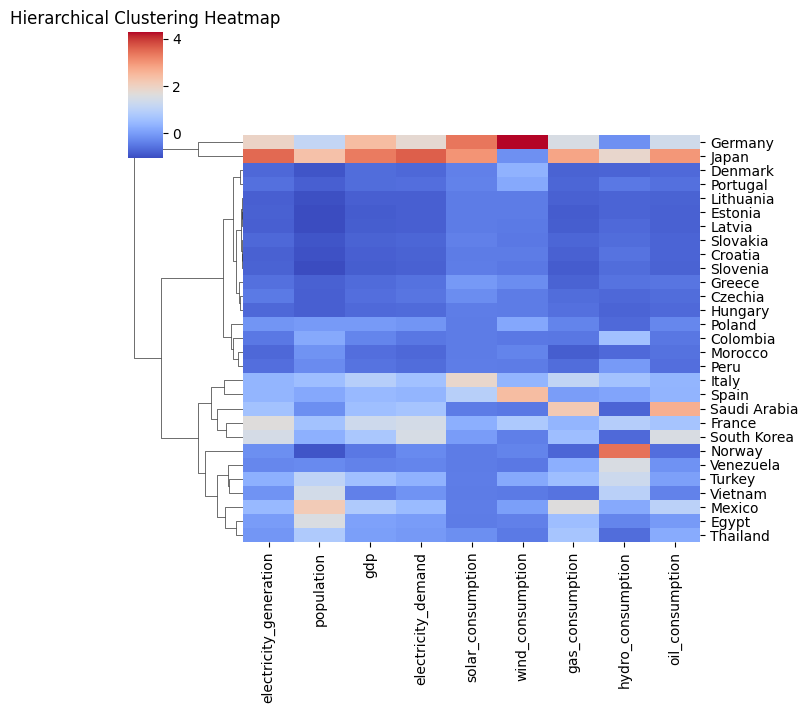

In [ ]:
# clustermap to visualize hierarchical clustering and feature distribution
g = sns.clustermap(df_scaled, method='ward', metric='euclidean',
               row_cluster=True, col_cluster=False,
               figsize=(7, 7), cmap="coolwarm",
               yticklabels=filtered_df['country'].values,
               xticklabels=filtered_df.drop(columns=['country']).columns)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.title("Hierarchical Clustering Heatmap")
plt.show()

####DISPLAY OF DENDROGRAMS OF MULTIPLE methods and metrics

In [ ]:

def make_hierarchical_cluster(df, method, distance_word, ax_dendro, ax_heatmap, map_clusters_method_distance):
    linked = linkage(df, method=method, metric=distance_word)
    map_clusters_method_distance.update({(method, distance_word): linked})

    dendrogram(linked, labels=filtered_df['country'].values, leaf_rotation=90, leaf_font_size=10, ax=ax_dendro)
    ax_dendro.set_title(f"Hierarchical Clustering Dendrogram\n{method} - {distance_word}")
    ax_dendro.set_ylabel("Distance")

    # g = sns.clustermap(df, method=method, metric=distance_word,
    #            row_cluster=True, col_cluster=False,
    #            figsize=(12, 12), cmap="coolwarm",
    #            yticklabels=filtered_df['country'].values,
    #            xticklabels=filtered_df.drop(columns=['country']).columns)
    # return g



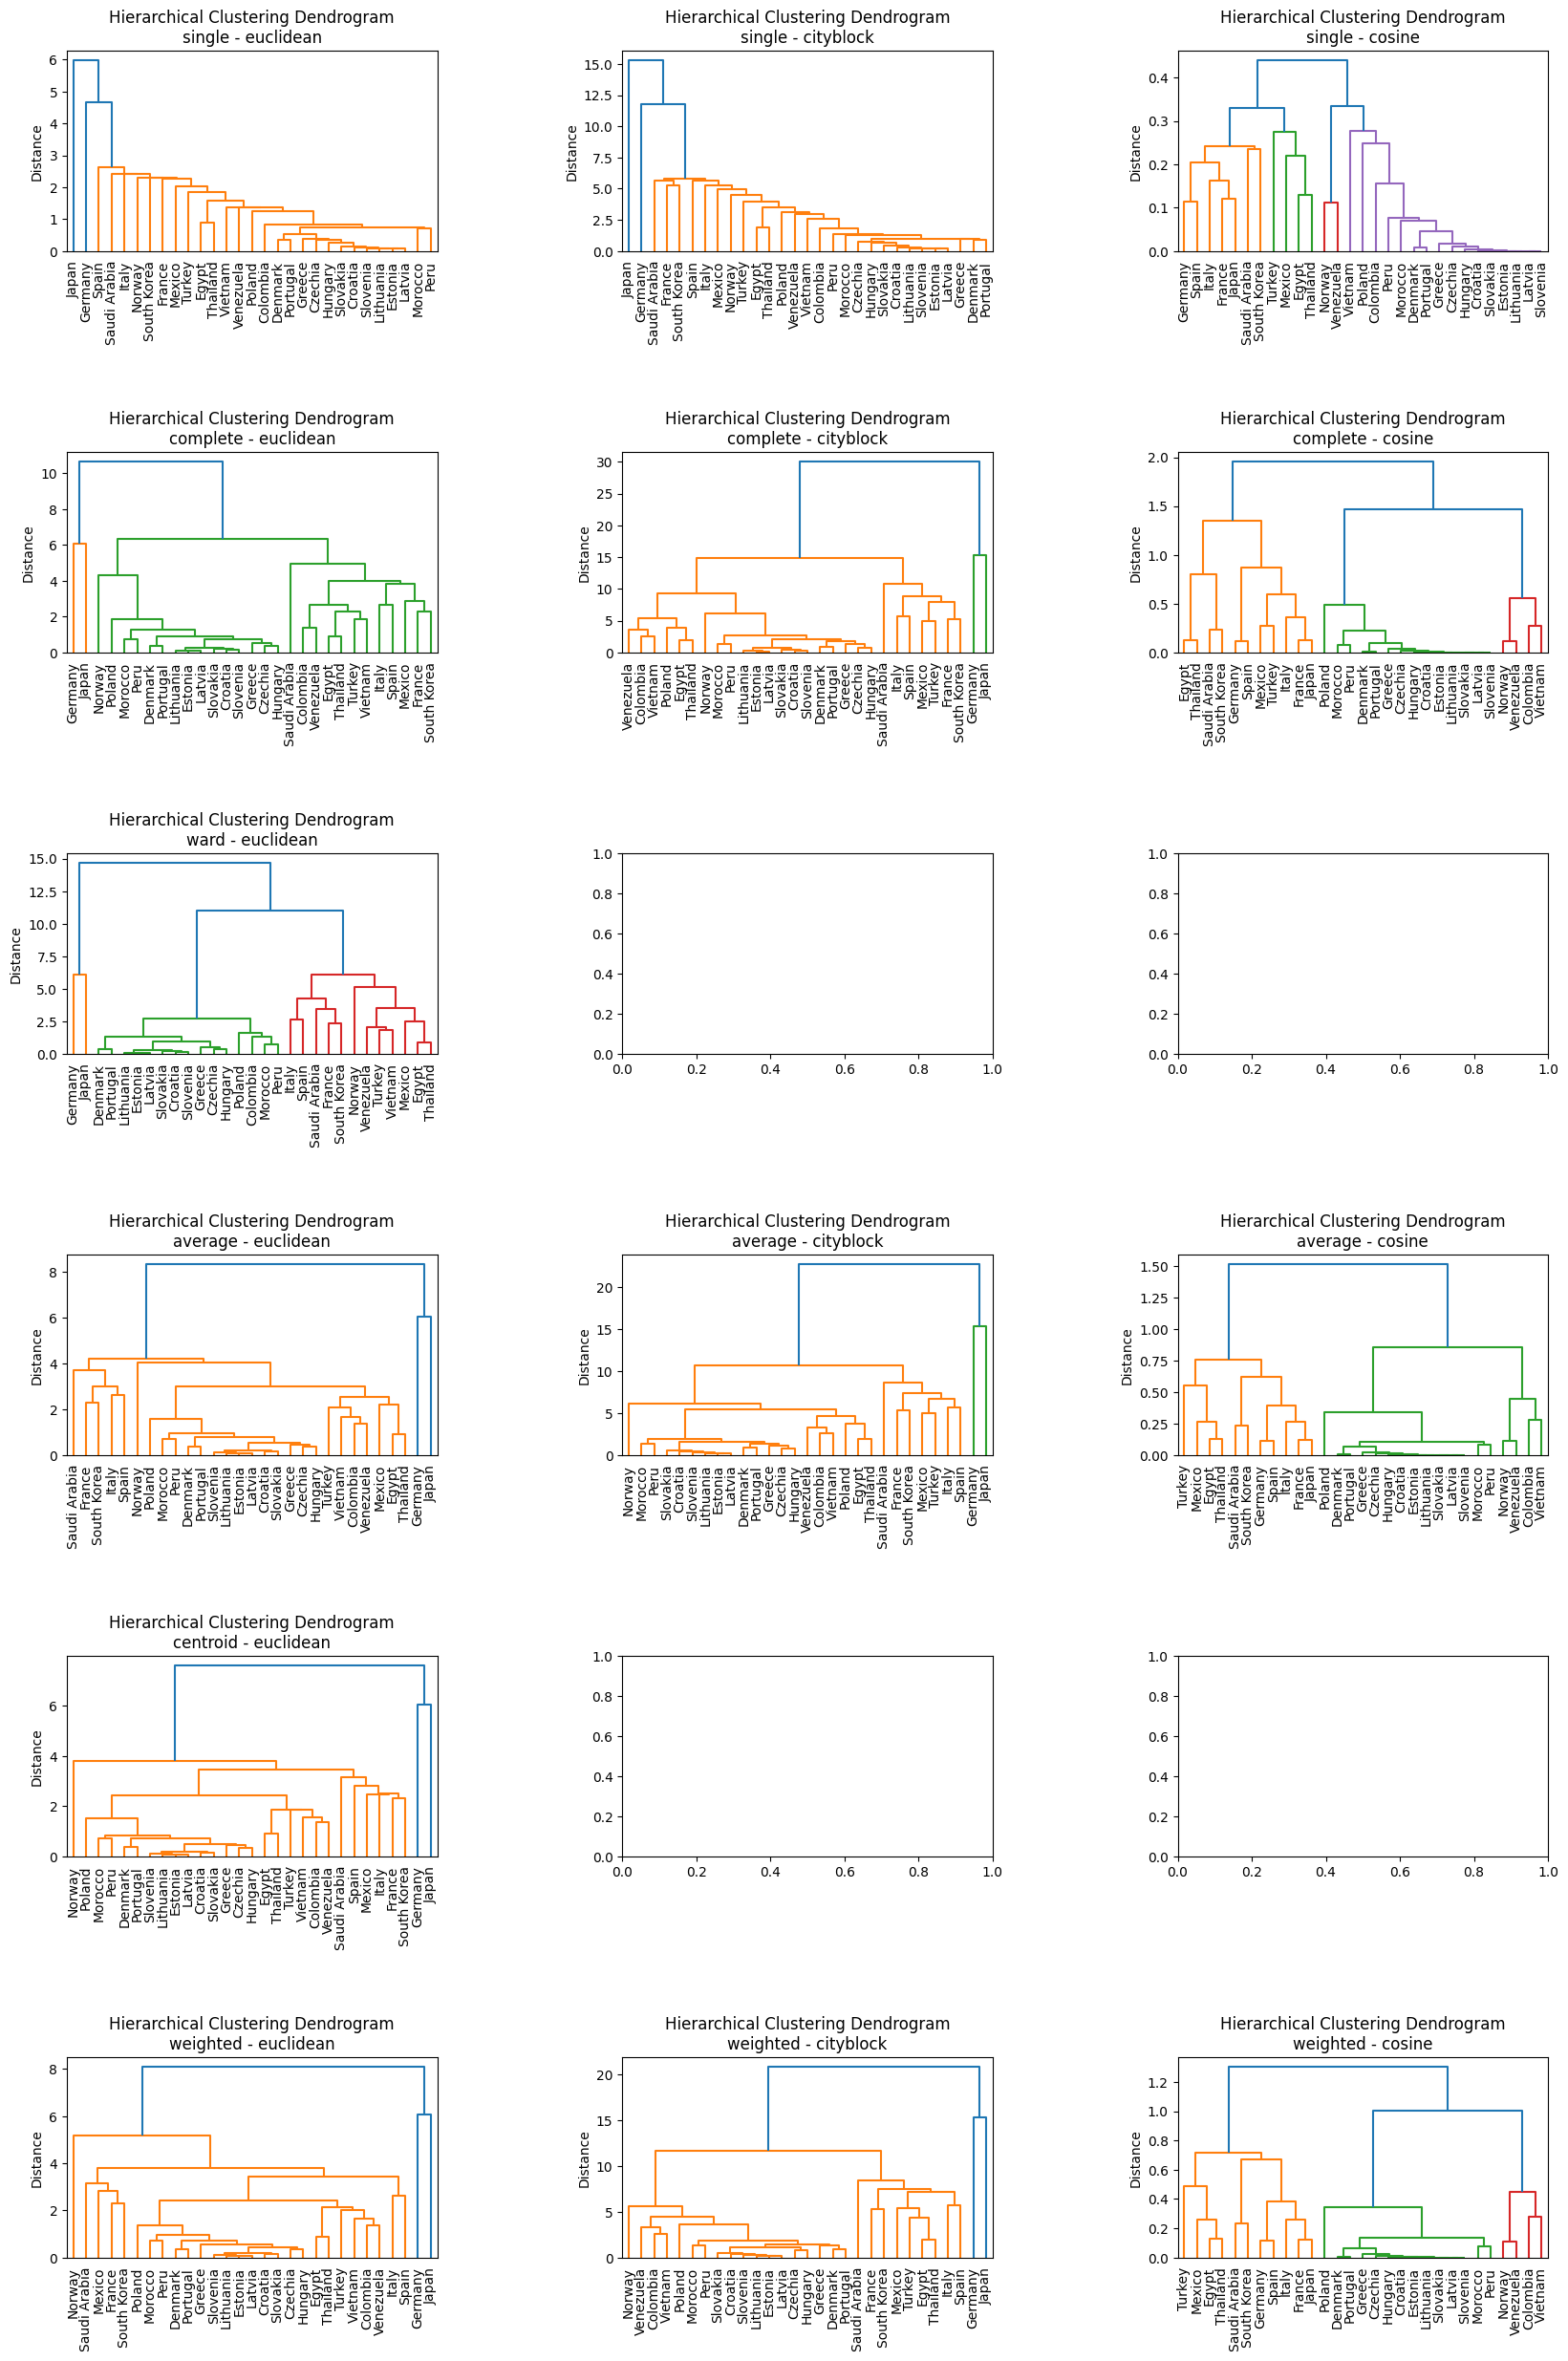

In [ ]:
methods=['single','complete', 'ward', 'average', 'centroid', 'weighted']
distances=['euclidean', 'cityblock', 'cosine']

map_clusters_method_distance = {}

n_methods = len(methods)
n_distances = len(distances)

fig, axes = plt.subplots(n_methods, n_distances, figsize=(20, 30), gridspec_kw={'hspace': 1, 'wspace': 0.5})

firstward = True
firstcentroid = True

for i, method in enumerate(methods):
    for j, distance in enumerate(distances):
        ax_dendro = axes[i, j]
        ax_heatmap = axes[i, j]
        if((method=='ward' and firstward) or (method=='centroid'and firstcentroid) ):
            make_hierarchical_cluster(df_scaled, method, 'euclidean', ax_dendro, ax_heatmap, map_clusters_method_distance)
            #g=make_hierarchical_cluster(df_scaled, method, 'euclidean', ax_dendro, ax_heatmap, map_clusters_method_distance)
            if(method=='ward'):
                firstward=False
            if(method=='centroid'):
                firstcentroid=False
        elif(method!='ward' and method!='centroid'):
          make_hierarchical_cluster(df_scaled, method, distance, ax_dendro, ax_heatmap, map_clusters_method_distance)
          #g=make_hierarchical_cluster(df_scaled, method, distance, ax_dendro, ax_heatmap, map_clusters_method_distance)

        #g.fig.suptitle(f"Clustermap\n{method} - {distance}", y=1.02)
        #plt.close(g.fig)


plt.savefig("hierarchical_clustering_grid.png", format='png', dpi=300)
plt.show()

####DISPLAY OF RELATIONSHIP BETWEEN ALL PAIRS OF COLUMNS

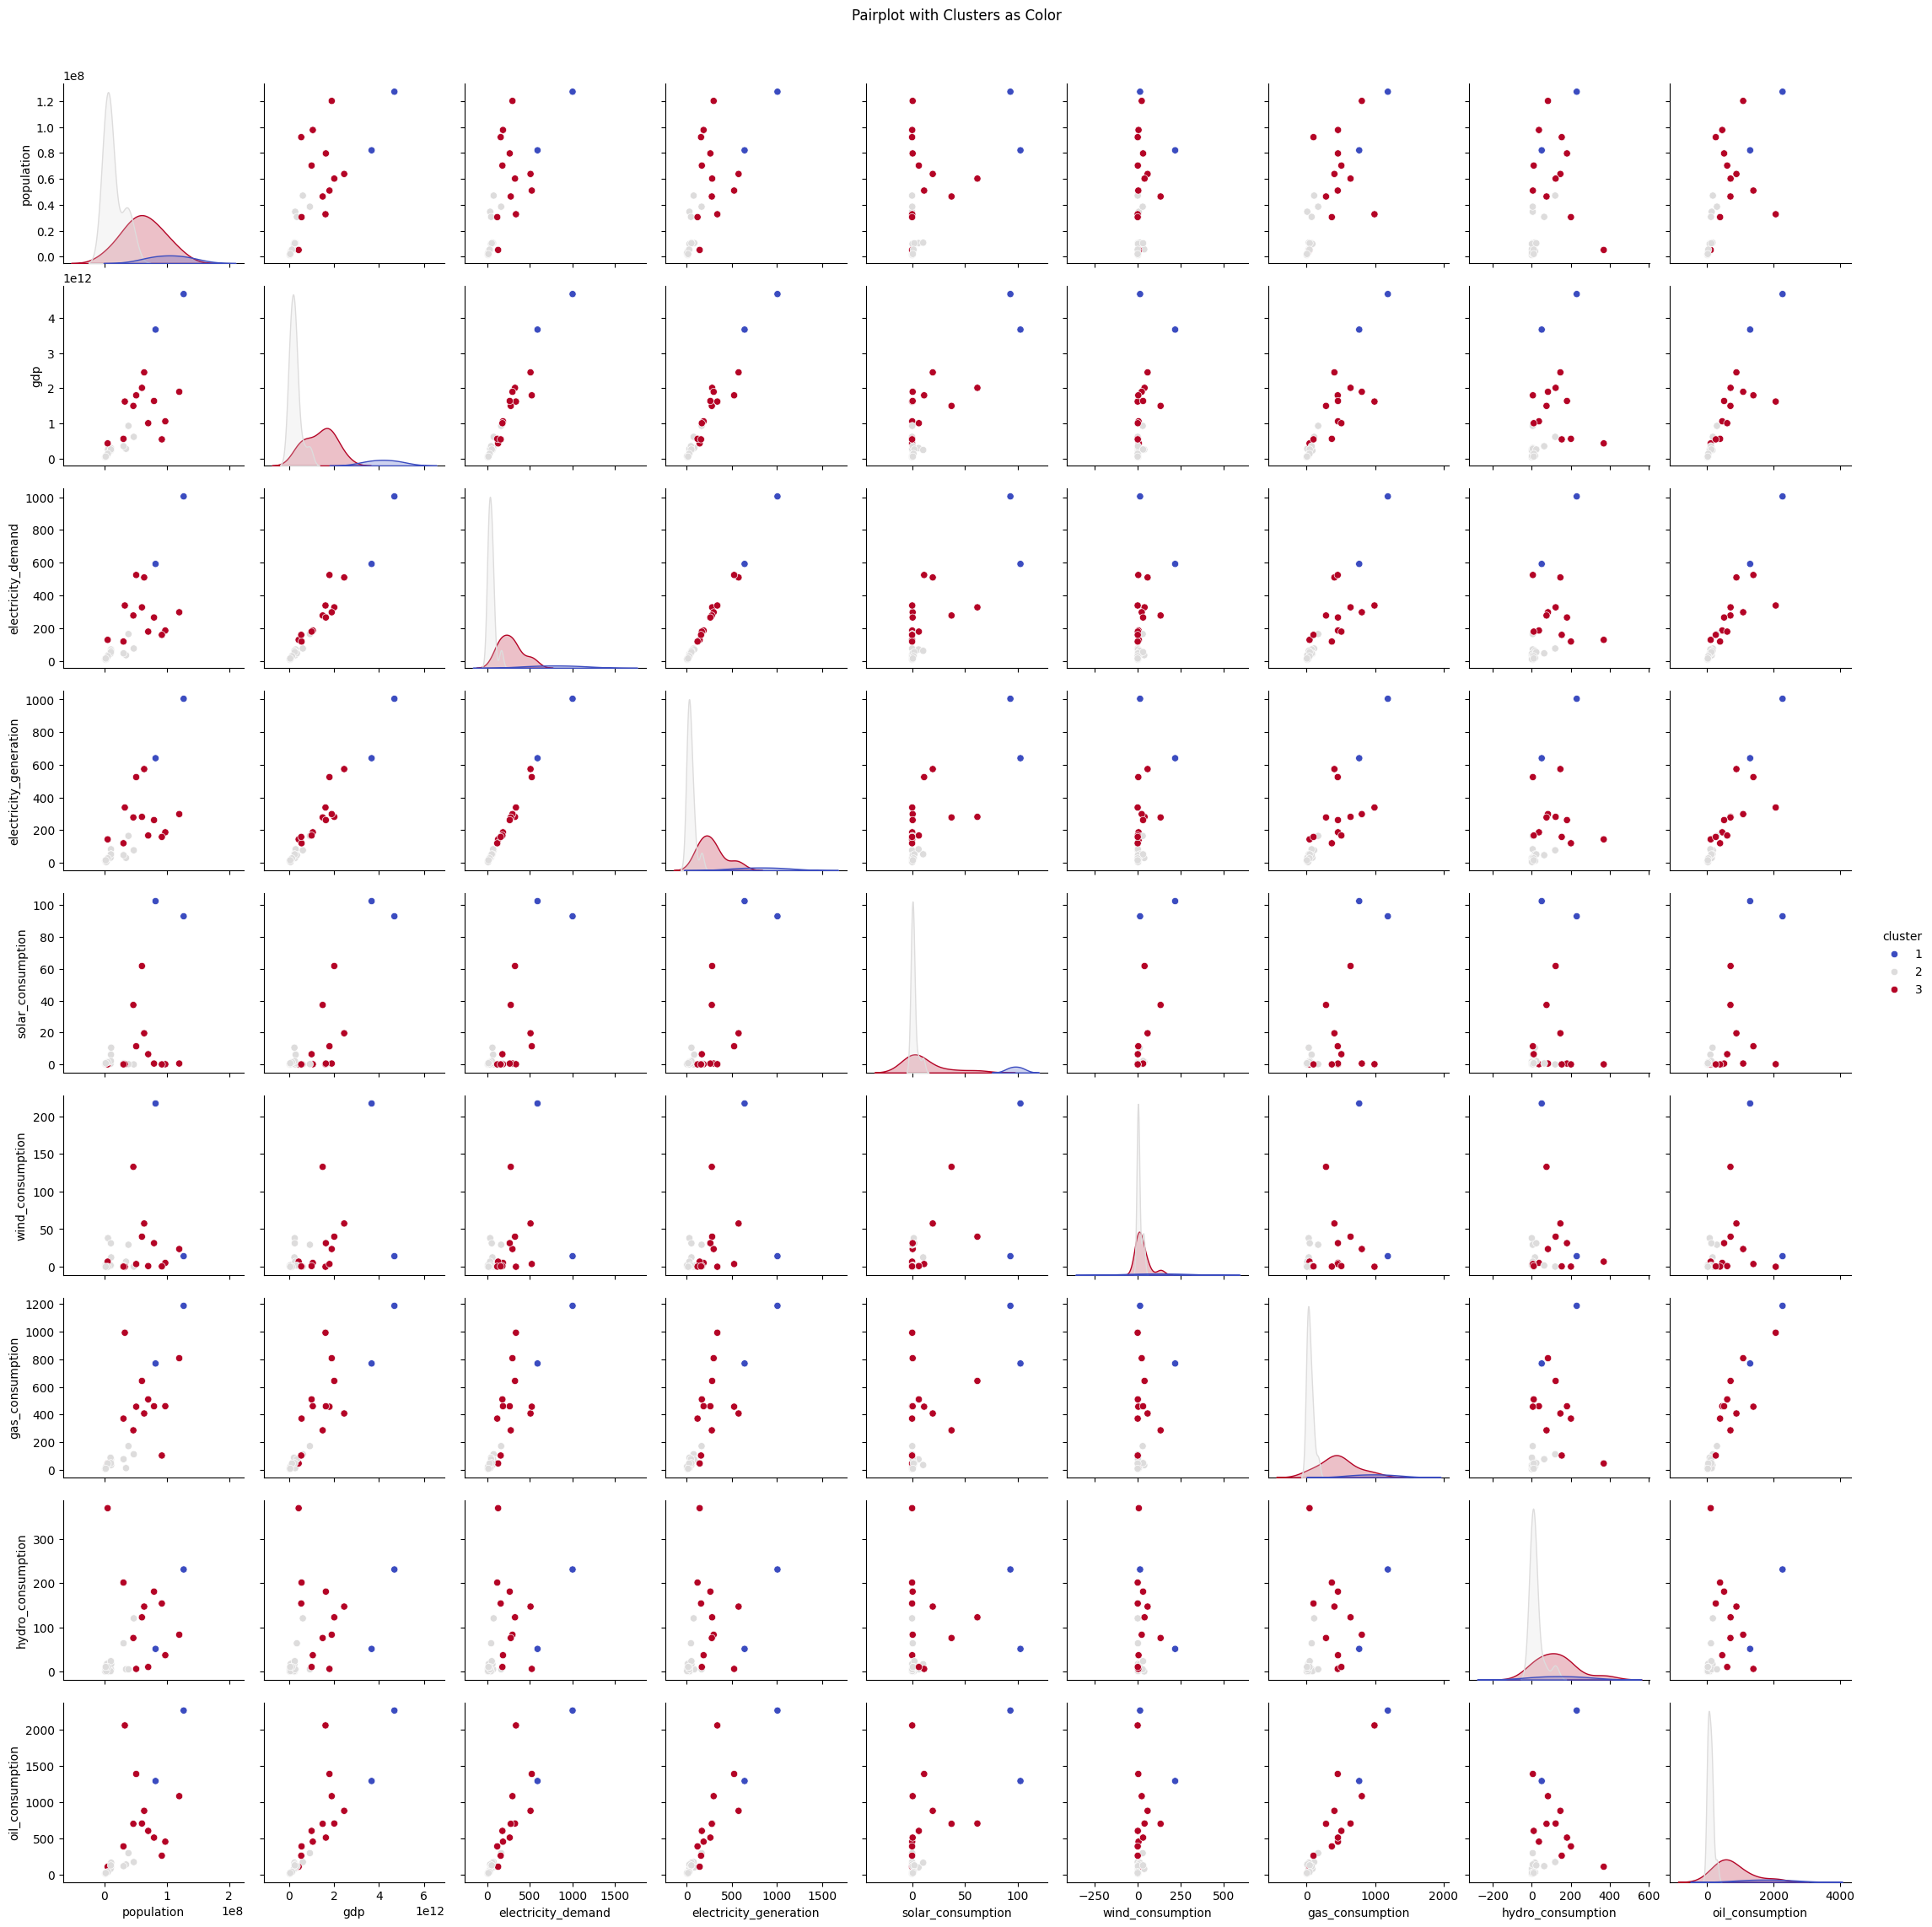

In [ ]:
num_clusters = 3 #initial chosen amount of clusters for demonstration
filtered_df['cluster'] = fcluster(linked, num_clusters, criterion='maxclust')

#clusters are hue
sns.pairplot(filtered_df, hue='cluster',
vars=['population', 'gdp', 'electricity_demand','electricity_generation', 'solar_consumption', 'wind_consumption', 'gas_consumption', 'hydro_consumption', 'oil_consumption'],
            palette="coolwarm")
plt.suptitle("Pairplot with Clusters as Color", y=1.02)
plt.savefig("hierarchical_clustering_pair_plots_3_clusters_big.png", format='png', dpi=300)
plt.show()



####DISPLAY OF COPHENETIC COEFFICIENTS

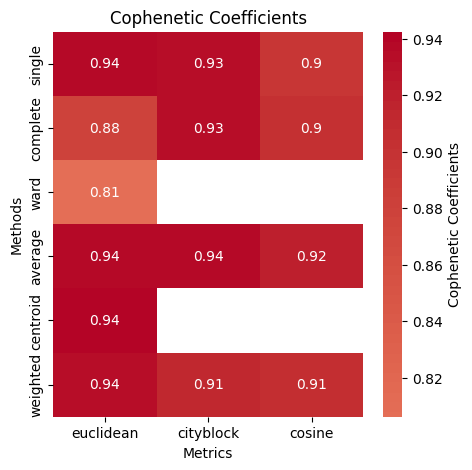

In [ ]:
ccc_values = pd.DataFrame(index=distances, columns=methods)

for key,value in map_clusters_method_distance.items():
    linked = value
    method = key[0]
    distance = key[1]
    pairwise_distances = pdist(df_scaled, metric=distance) #(n * (n - 1) / 2 = 29 * 28 / 2 = 406).
    coph_distances, _ = cophenet(linked, pairwise_distances)

    ccc_values.loc[distance, method] = coph_distances

ccc_values = ccc_values.astype(float)

plt.figure(figsize=(5, 5))
sns.heatmap(ccc_values.transpose(), annot=True, cmap='coolwarm', center=0.5, cbar_kws={'label': 'Cophenetic Coefficients'})
plt.title("Cophenetic Coefficients")
plt.ylabel("Methods")
plt.xlabel("Metrics")
plt.show()



####DISPLAY OF INCONSISTENCY COEFFICIENTS

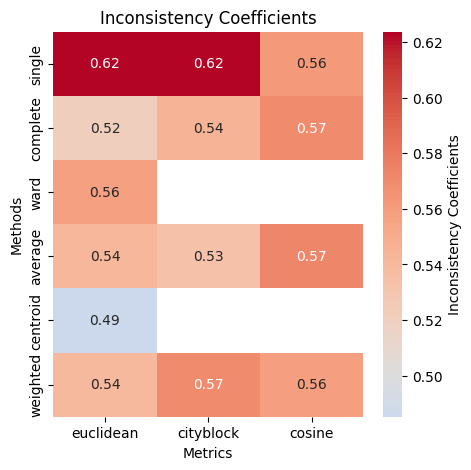

In [ ]:
inc_values = pd.DataFrame(index=distances, columns=methods)

for key,value in map_clusters_method_distance.items():
    linked = value
    method = key[0]
    distance = key[1]
    inconsistency_matrix = inconsistent(linked)
    avg_inconsistency = np.mean(inconsistency_matrix[:, -1])  # Using the last column -> inconsistency coefficient
    inc_values.loc[distance, method] = avg_inconsistency

inc_values = inc_values.astype(float)

plt.figure(figsize=(5, 5))
sns.heatmap(inc_values.transpose(), annot=True, cmap='coolwarm', center=0.5, cbar_kws={'label': 'Inconsistency Coefficients'})
plt.title("Inconsistency Coefficients")
plt.ylabel("Methods")
plt.xlabel("Metrics")
plt.show()



-----------------------------------------------------------------------------

---------------------------------------------------------------------------------
------------------------------------------------------------------------------


In [ ]:
#support methods for plotting

def make_single_dendrogram(df_fil, method, distance_word, linked):
  plt.figure(figsize=(5, 5))
  dendrogram(linked, labels=df_fil['country'].values, leaf_rotation=90, leaf_font_size=10)
  plt.title(f"Hierarchical Clustering Dendrogram\nmethod:{method} metrics:{distance_word}")
  plt.xlabel("Country")
  plt.ylabel("Distance")
  plt.show()

def make_single_cluster_map(df_sc,df_filt, distance, method):
  g = sns.clustermap(df_sc, method=method, metric=distance,
               row_cluster=True, col_cluster=False,
               figsize=(7, 7), cmap="coolwarm",
               yticklabels=df_filt['country'].values,
               xticklabels=df_filt.drop(columns=['country']).columns)
  plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
  plt.title(f'Hierarchical Clustering Heatmap\nmethod:{method} metrics:{distance}')
  plt.show()

def make_single_pairplot(df_fil, vars):
  sns.pairplot(df_fil,
               hue='cluster',
               vars=vars,
               palette="coolwarm")
  plt.suptitle("Pairplot with Clusters as Color", y=1.02)
  plt.show()

def make_single_3D_triple_plot(df_fil,selected_columns, cluster_labels, tresh, crit, km): #df= filtered
  unique_clusters = len(set(cluster_labels))
  cmap = ListedColormap(sns.color_palette("tab10", unique_clusters).as_hex())

  df_3d = df_fil[selected_columns].values

  fig = plt.figure(figsize=(12, 5))
  ax = fig.add_subplot(111, projection='3d')

  title=f'Hierarchical Clustering 3D Visualization\ntreshold: {tresh} criterion: {crit}\nmethod:{method} metrics:{distance}'
  if (km==True):
    title=f'K-means Clustering 3D Visualization\nmethod:{method} metrics:{distance}'

  scatter = ax.scatter(df_3d[:, 0], df_3d[:, 1], df_3d[:, 2],
                      c=cluster_labels, cmap=cmap, s=50)


  ax.set_xlabel(selected_columns[0])
  ax.set_ylabel(selected_columns[1])
  ax.set_zlabel(selected_columns[2])
  ax.set_title(title)

  cbar = plt.colorbar(scatter)
  cbar.set_label('Cluster Label')


  plt.show()

def make_singe_3d_responsive_triple_plot(df_fil, df_sc,selected_columns, cluster_labels, tresh, crit, km):

  df_3d = filtered_df[selected_columns].values

  df_3d_scaled = df_3d

  country_names = filtered_df['country'].values

  cluster_labels_str = cluster_labels.astype(str)
  title=f'Hierarchical Clustering 3D Visualization\ntreshold: {tresh} criterion: {crit}\nmethod:{method} metrics:{distance}'
  if (km==True):
    title=f'K-means Clustering 3D Visualization\nmethod:{method} metrics:{distance}'

  fig = px.scatter_3d(
      x=df_3d_scaled[:, 0],
      y=df_3d_scaled[:, 1],
      z=df_3d_scaled[:, 2],
      color=cluster_labels_str,
      labels={'x': selected_columns[0], 'y': selected_columns[1], 'z': selected_columns[2], 'color': "Clusters"},
      title=title,
      color_continuous_scale='Viridis',
      hover_data={'country': country_names}
  )


  fig.show()


####DISPLAY OF CHOOSEN FOR COMPARISON WITH CHANGING TRESHOLD, CRITERIONS

dict_keys([('single', 'euclidean'), ('single', 'cityblock'), ('single', 'cosine'), ('complete', 'euclidean'), ('complete', 'cityblock'), ('complete', 'cosine'), ('ward', 'euclidean'), ('average', 'euclidean'), ('average', 'cityblock'), ('average', 'cosine'), ('centroid', 'euclidean'), ('weighted', 'euclidean'), ('weighted', 'cityblock'), ('weighted', 'cosine')])


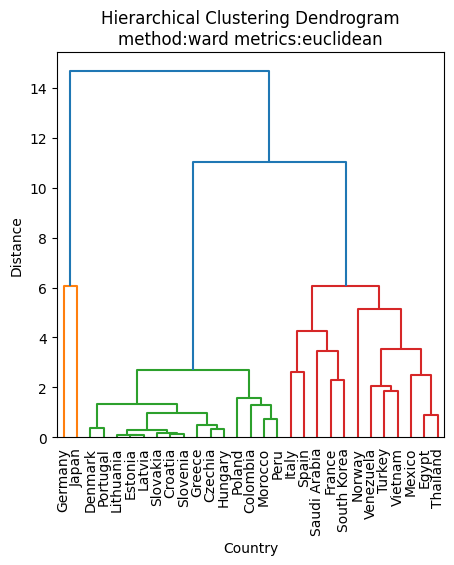

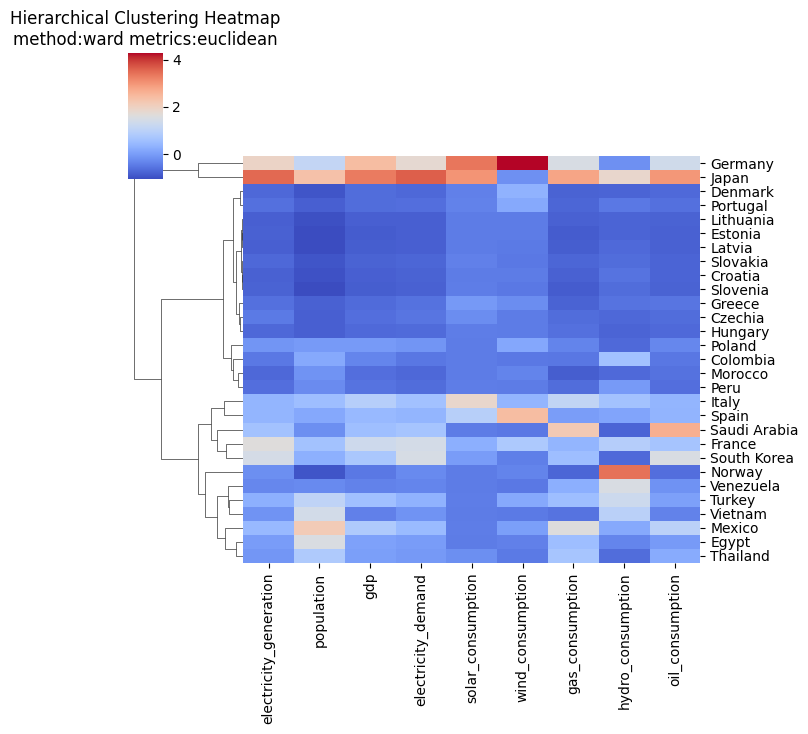

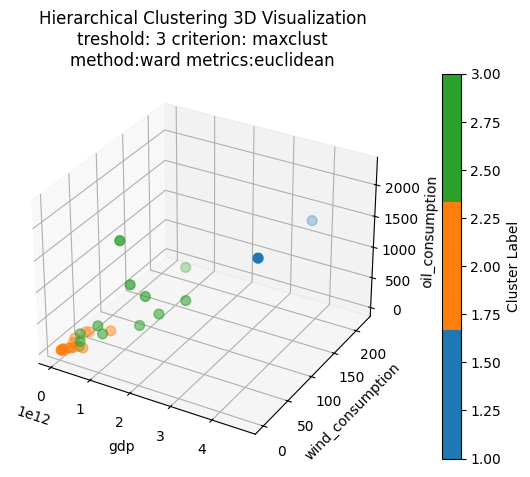

---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------


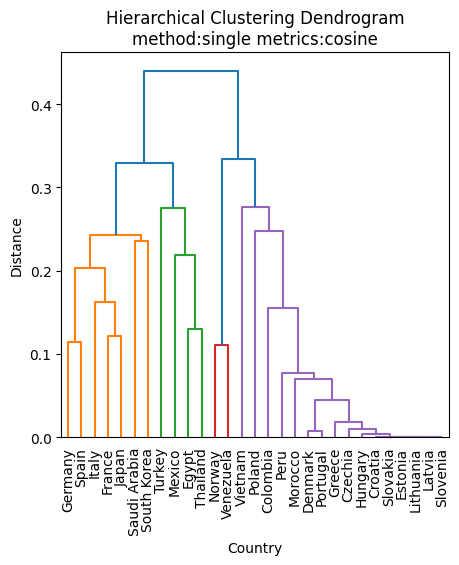

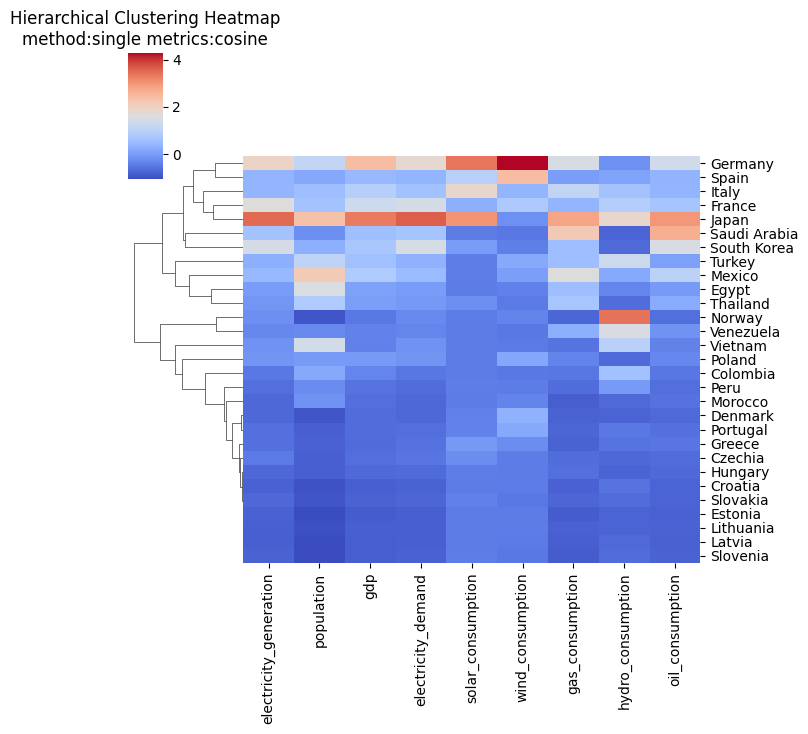

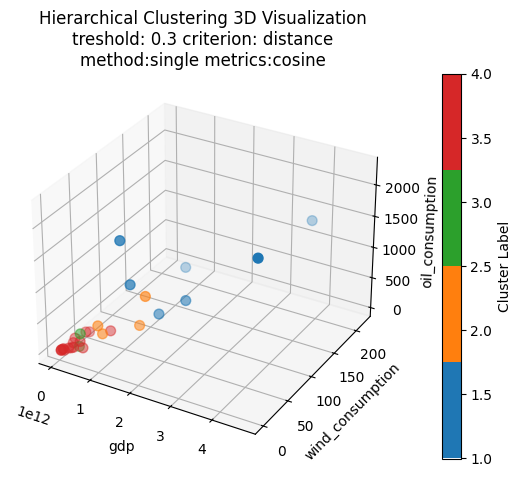

---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------


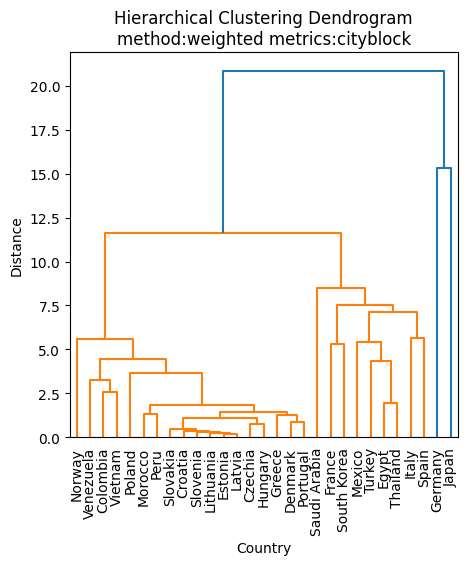

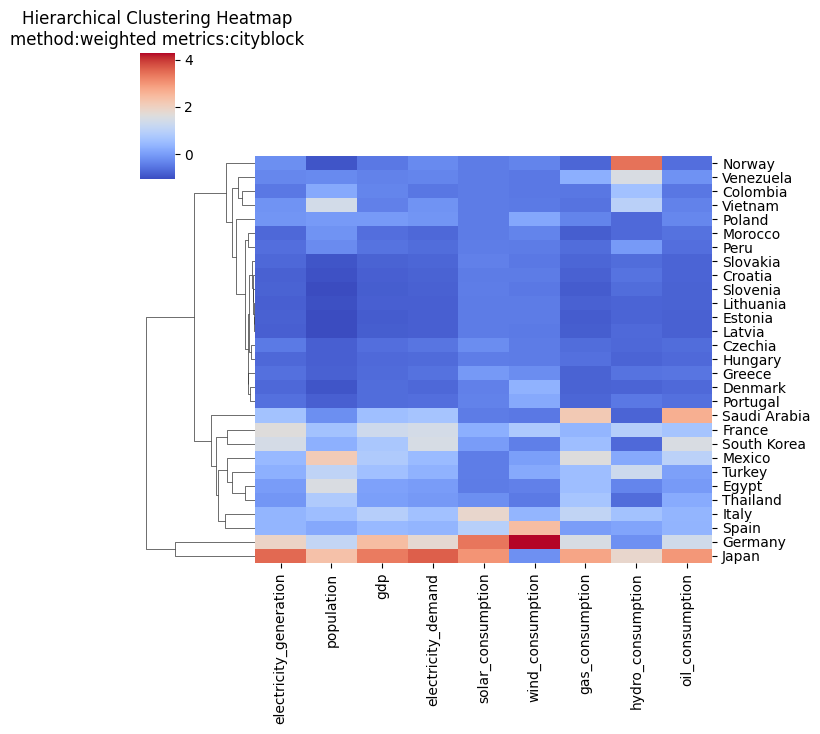

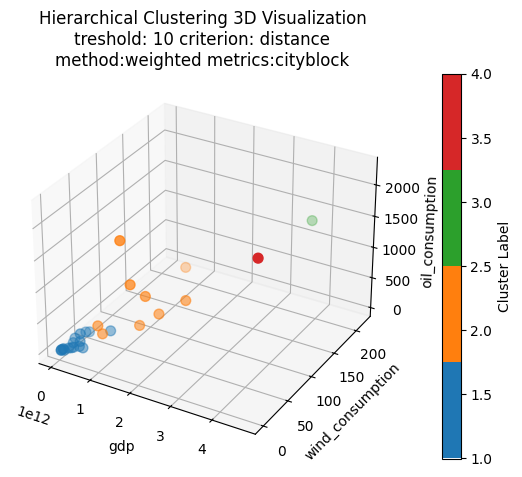

---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
pairs = [['ward', 'euclidean'], ['single', 'cosine'], ['weighted', 'cityblock']]
tresholds = [3,0.3, 10]
criterions = ['maxclust', 'distance', 'distance']
print(map_clusters_method_distance.keys())

for pair in pairs:
    i = pairs.index(pair)
    method = pair[0]
    distance = pair[1]
    linked = map_clusters_method_distance[(method, distance)]
    make_single_dendrogram(filtered_df, method, distance, linked)
    make_single_cluster_map(df_scaled, filtered_df, distance, method)
    treshold = tresholds[i]
    criterion = criterions[i]
    clus = fcluster(linked, treshold, criterion=criterion)
    filtered_df['hierarchical_cluster'] = clus
    make_single_3D_triple_plot(filtered_df, ['gdp', 'wind_consumption','oil_consumption'], clus, treshold, criterion, False)
    make_singe_3d_responsive_triple_plot(filtered_df,df_scaled, ['gdp', 'wind_consumption','oil_consumption'], clus, treshold, criterion, False)
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")

####COMPARISON WITH K-MEANS

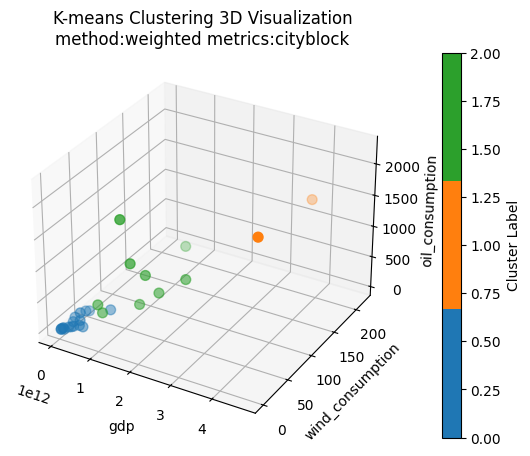

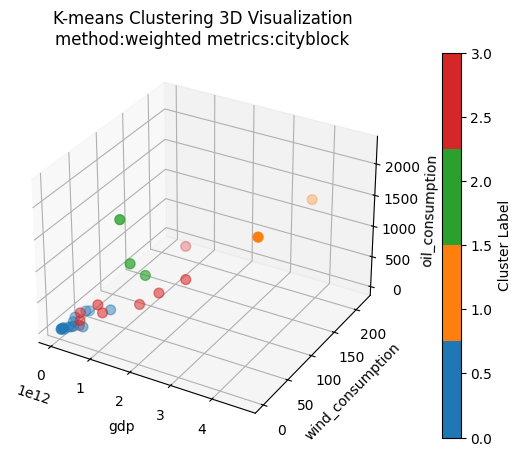

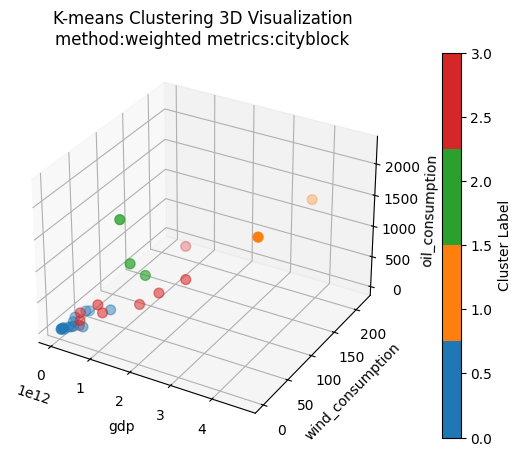

In [ ]:


clusters_our = [3,4,4]

for cluster in clusters_our:
  num_clusters = cluster

  kmeans = KMeans(n_clusters=num_clusters, random_state=0)
  kmeans_labels = kmeans.fit_predict(df_scaled)

  make_single_3D_triple_plot(filtered_df, ['gdp', 'wind_consumption','oil_consumption'], kmeans_labels, "-", "-", True)
  make_singe_3d_responsive_triple_plot(filtered_df, df_scaled, ['gdp', 'wind_consumption','oil_consumption'],
                                      kmeans_labels, "/", "-", True)


  filtered_df['kmeans_cluster'] = kmeans_labels

  plt.show()




In [ ]:

kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.2f}")

hierarchical_silhouette = silhouette_score(df_scaled, clus)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.2f}")


K-means Silhouette Score: 0.41
Hierarchical Clustering Silhouette Score: 0.44
